In [1]:
!nvidia-smi

Fri Jan 17 04:00:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   30C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 29%   34C    P0    77W / 250W |     10MiB / 11019MiB |     40%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
from itertools import product
import glob

def target_preprocessings(phase_a_switch = [1, 1, 1], phase_b_switch = True, mode = 'load'):
    """
    phase_a_switch = [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
    that means [flip, rotate, blur_sharp]
    """
    phase0 = ['_c']
    phase1 = {1: ['-', 'f'], 0: ['-']}
    phase2 = {1: ['-', 'r1', 'r2', 'r3'], 0: ['-']}
    phase3 = {1: ['-', 'ab', 'mb', 'eh'], 0: ['-']}
    phase4 = ['s_-30_v_30', 's_-30_v_-30', 's_30_v_-30', 's_30_v_30']
    
    if mode == 'load':
        phase_a_items = [phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    elif mode == 'preprocessing':
        phase_a_items = [phase0, phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    
    phase_a = []
    for i in list(product(*phase_a_items)):
        phase_a.append('_'.join(i))

    if not phase_b_switch != True:
        phase_b = []
        for i in list(product(*[phase_a, phase4])):
            phase_b.append('_'.join(i))
        return list(np.hstack([phase_a, phase_b]))
    else:
        return phase_a 

class ce_load_dataset:
    def __init__(self, phase, data, pre_a, pre_b, img_ch = 'bgr', ext_name = True):
        self.phase = phase        # 'train' or 'test'
        self.data = data          # 'sm', 'sm_core', 'sm_v2', 'sm_x160', ...
        self.pre_a = pre_a        # [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
        self.pre_b = pre_b        # True or False
        self.img_ch = img_ch      # 'bgr', 'rgb', and 'hsv'
        self.ext_name = ext_name  # True or False

    def load_path(self, cls, les, data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'):
        """
        phase = 'train', 'test'
        cls: [les]  
          'n': ['neg']
          'h': ['redspot', 'angio', 'active'], 
          'd': ['ero', 'ulc', 'str'],
          'p': ['amp', 'lym', 'tum']}
        pre_a[0] must be 0
        """
        lesions = dict(neg = 'negative', 
                       redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                       ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                       amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
        classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

        path = os.path.join(data_dir, self.data, self.phase, classes[cls], lesions[les])
        pathlist = glob.glob(path + '/*.jpg')
        if self.pre_a != [1, 1, 1] and self.pre_b != True:
            path_in_phase = []
            for p in pathlist:
                name = os.path.basename(p)
                if (name.split('c_')[-1])[:-4] in target_preprocessings(self.pre_a, self.pre_b):
                    path_in_phase.append(p)   
            return np.asarray(path_in_phase)
        else:
            return np.asarray(pathlist)

    def load_image_from_path(self, pathlist,image_ch = 'bgr', extract_name = False):
        data = []
        for i in pathlist:
            temp = cv2.imread(i)
            if image_ch == 'bgr':
                pass
            elif image_ch == 'rgb':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            elif image_ch == 'hsv':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
            data.append(temp)
        if extract_name != False:
            name = []
            for i in pathlist:
                name.append(os.path.basename(i))
            return np.asarray(data), np.asarray(name)
        else:
            return np.asarray(data) 

    def load_data(self, cls, les):
        pathlist = self.load_path(cls, les)
        return  self.load_image_from_path(pathlist, image_ch = self.img_ch, extract_name = self.ext_name)

In [4]:
ce = ce_load_dataset(phase = 'test', data = 'sm_x160', pre_a = [1, 1, 1], pre_b = True)

In [5]:
neg_testset = ce.load_data('n', 'neg')
redspot_testset = ce.load_data('h', 'redspot')
angio_testset = ce.load_data('h', 'angio')
active_testset = ce.load_data('h', 'active')
ero_testset = ce.load_data('d', 'ero')
ulcer_testset = ce.load_data('d', 'ulcer')
str_testset = ce.load_data('d', 'str')

neg_label = one_hot(neg_testset[0], 0)
redspot_label = one_hot(redspot_testset[0], 1)
angio_label = one_hot(angio_testset[0], 1)
active_label = one_hot(active_testset[0], 1)
ero_label = one_hot(ero_testset[0], 1)
ulcer_label = one_hot(ulcer_testset[0], 1)
str_label = one_hot(str_testset[0], 1)

print("negative:",neg_testset[0].shape, neg_label.shape)
print("red spot:",redspot_testset[0].shape, redspot_label.shape)
print("angioectasia:",angio_testset[0].shape, angio_label.shape)
print("active_bleeding:",active_testset[0].shape, active_label.shape)
print("erosion:",ero_testset[0].shape, ero_label.shape)
print("ulcer:",ulcer_testset[0].shape, ulcer_label.shape)
print("stricture:",str_testset[0].shape, str_label.shape)

negative: (11592, 512, 512, 3) (11592, 2)
red spot: (18240, 512, 512, 3) (18240, 2)
angioectasia: (480, 512, 512, 3) (480, 2)
active_bleeding: (19520, 512, 512, 3) (19520, 2)
erosion: (19360, 512, 512, 3) (19360, 2)
ulcer: (22560, 512, 512, 3) (22560, 2)
stricture: (4960, 512, 512, 3) (4960, 2)


In [6]:
neg_testset[1]

array(['CW___02-49-14___1020312__c_-_-_-.jpg',
       'CW___02-49-14___1020312__c_-_-_ab.jpg',
       'CW___02-49-14___1020312__c_-_-_mb.jpg', ...,
       '희정___05-21-26___2053556__c_f_-_ab.jpg',
       '희정___05-21-26___2053556__c_f_-_mb.jpg',
       '희정___05-21-26___2053556__c_f_-_eh.jpg'], dtype='<U37')

# Model Inference

In [7]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8H' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8D' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8A' in i])

In [8]:
nh_list

['X160_NX8H_2001161706_1780_val_acc_1.00_val_loss_0.000070',
 'X160_NX8H_2001161804_4660_val_acc_1.00_val_loss_0.000001',
 'X160_NX8H_2001161845_6680_val_acc_1.00_val_loss_0.000000',
 'X160_NX8H_2001162013_11010_val_acc_1.00_val_loss_0.000000',
 'X160_NX8H_2001162030_11850_val_acc_1.00_val_loss_0.000000']

In [9]:
b_list

['X160_NX8A_2001170050_27000_val_acc_1.00_val_loss_0.000312',
 'X160_NX8A_2001170202_30970_val_acc_1.00_val_loss_0.000305',
 'X160_NX8A_2001170213_31610_val_acc_1.00_val_loss_0.000274',
 'X160_NX8A_2001170222_32080_val_acc_1.00_val_loss_0.000154',
 'X160_NX8A_2001170247_33510_val_acc_1.00_val_loss_0.000099']

In [10]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0117 04:05:14.821601 139694394013440 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0117 04:05:15.136008 139694394013440 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:109: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0117 04:05:15.434595 139694394013440 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [11]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_testset[0], model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_testset[0], model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_testset[0], model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_testset[0], model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_testset[0], model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_testset[0], model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_testset[0], model_type = 'ensemble')

#: 11592 / Inference Time: 00:01:09
#: 18240 / Inference Time: 00:01:47
#: 480 / Inference Time: 00:00:04
#: 19520 / Inference Time: 00:02:03
#: 19360 / Inference Time: 00:02:08
#: 22560 / Inference Time: 00:02:29
#: 4960 / Inference Time: 00:00:35


In [12]:
neg_b_output = model_prob(B_model, neg_testset[0])
redspot_b_output = model_prob(B_model, redspot_testset[0])
angio_b_output = model_prob(B_model, angio_testset[0])
active_b_output = model_prob(B_model, active_testset[0])
ero_b_output = model_prob(B_model, ero_testset[0])
ulcer_b_output = model_prob(B_model, ulcer_testset[0])
str_b_output  = model_prob(B_model, str_testset[0])

#: 11592 / Inference Time: 00:00:38
#: 18240 / Inference Time: 00:01:01
#: 480 / Inference Time: 00:00:01
#: 19520 / Inference Time: 00:01:01
#: 19360 / Inference Time: 00:01:06
#: 22560 / Inference Time: 00:01:19
#: 4960 / Inference Time: 00:00:19


# Evaluation

In [13]:
cls = classification_metric()

## Accuracy per lesion

In [14]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 97.52 %
Accuracy: 92.52 %
Accuracy: 98.12 %
Accuracy: 93.28 %


In [15]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 97.29 %
Accuracy: 99.05 %
Accuracy: 97.74 %
Accuracy: 99.84 %


In [16]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.51 %
Accuracy: 98.82 %
Accuracy: 100.00 %
Accuracy: 99.78 %
Accuracy: 99.17 %
Accuracy: 97.88 %
Accuracy: 99.60 %


In [17]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 95.39 %
Accuracy: 98.53 %
Accuracy: 100.00 %
Accuracy: 99.60 %
Accuracy: 99.09 %
Accuracy: 98.21 %
Accuracy: 99.92 %


## Confusion Matrix

In [18]:
h_label = np.vstack([redspot_label, angio_label, active_label])
d_label = np.vstack([ero_label, ulcer_label, str_label])
labels = np.vstack([neg_label, h_label, d_label])

h_b_output = np.vstack([redspot_b_output, angio_b_output, active_b_output])
d_b_output = np.vstack([ero_b_output, ulcer_b_output, str_b_output])
b_outputs = np.vstack([neg_e_output, h_b_output, d_b_output])

h_e_output = np.vstack([redspot_e_output, angio_e_output, active_e_output])
d_e_output = np.vstack([ero_e_output, ulcer_e_output, str_e_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

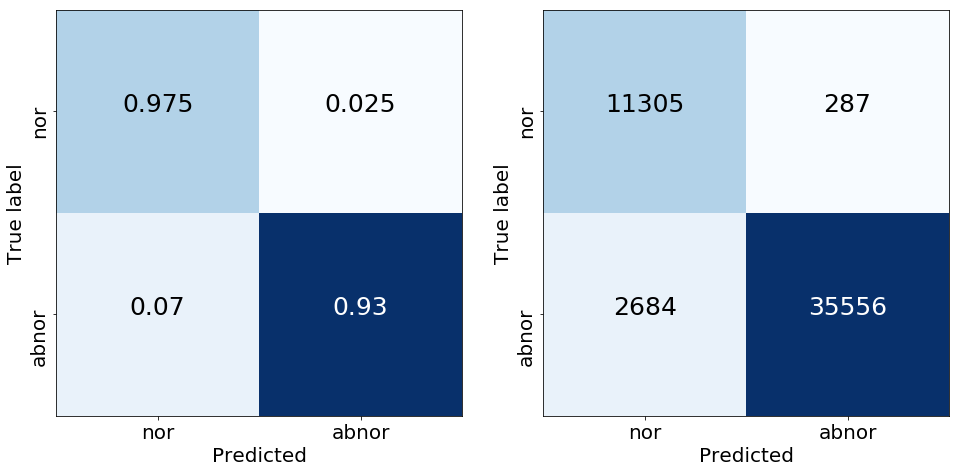

In [19]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
nh_labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(nh_labels, nh_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

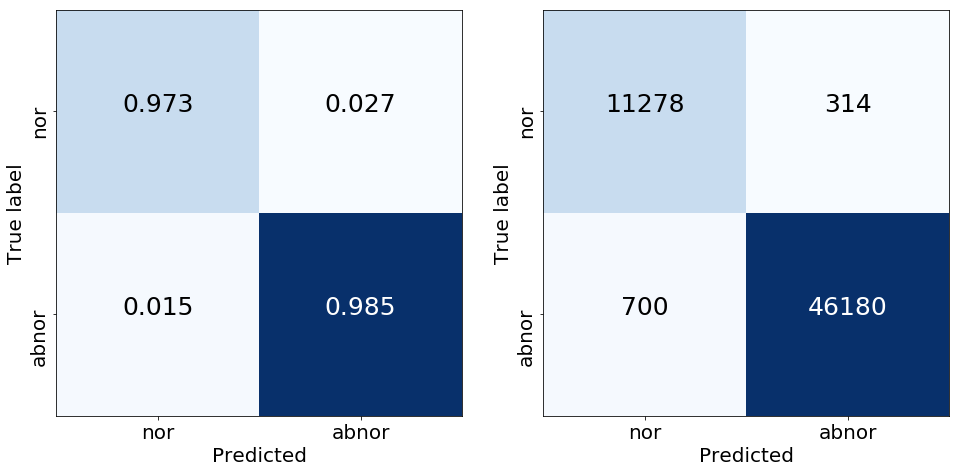

In [20]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
nd_labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(nd_labels, nd_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

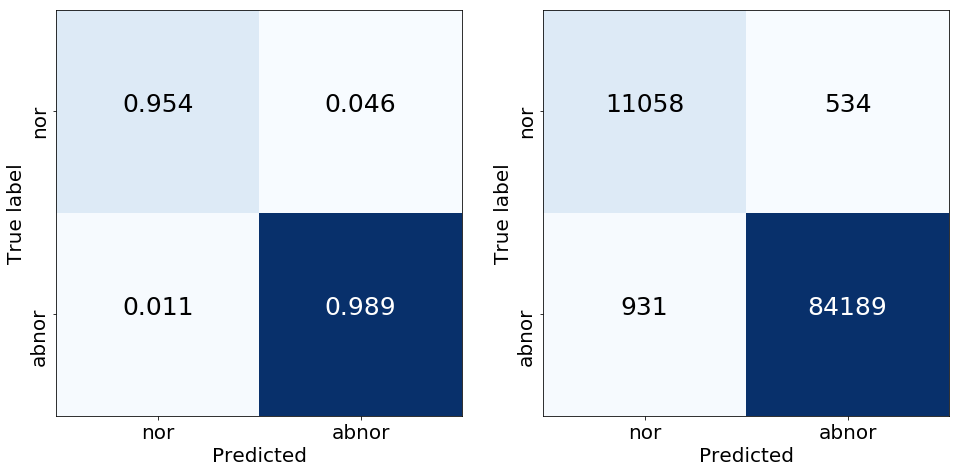

In [21]:
e_CM = cls.con_mat(labels, e_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

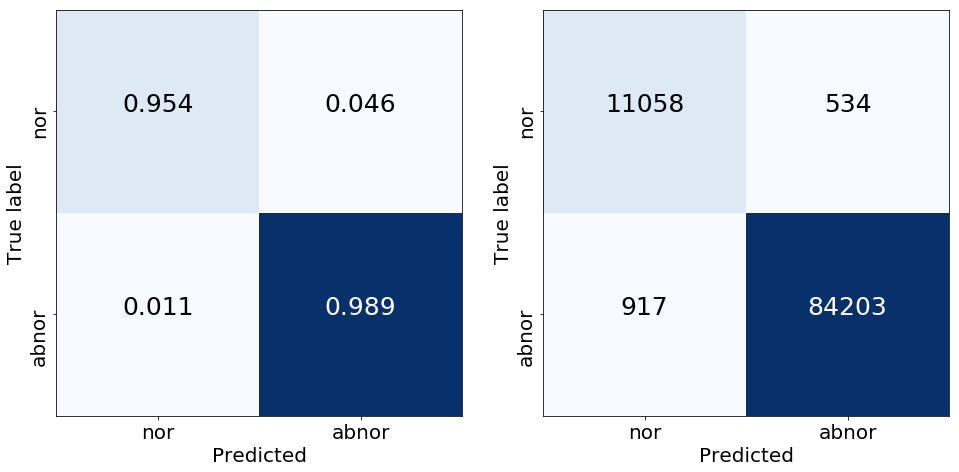

In [22]:
b_CM = cls.con_mat(labels, b_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## False cases

In [23]:
testset = np.vstack([neg_testset[0], redspot_testset[0], angio_testset[0], active_testset[0], 
                      ero_testset[0], ulcer_testset[0], str_testset[0]])

filename = np.hstack([neg_testset[1], redspot_testset[1], angio_testset[1], active_testset[1], 
                      ero_testset[1], ulcer_testset[1], str_testset[1]])

In [24]:
def fp_fn_list(name, prob, label):

    pred = np.argmax(prob, axis = 1)
    true = np.argmax(label, axis = 1)

    fp_list, fn_list = [], []
    for n, p, t in zip(name, pred, true):
        if p == 1:
            if p != t:
                fp_list.append(n)
        elif p == 0:
            if p != t:
                fn_list.append(n)
    return np.asarray(fp_list), np.asarray(fn_list)

In [25]:
b_fp_list, b_fn_list = fp_fn_list(name = filename, prob = b_outputs, label = labels)
e_fp_list, e_fn_list = fp_fn_list(name = filename, prob = e_outputs, label = labels)

In [26]:
b_fp_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in b_fp_list])]
b_fn_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in b_fn_list])]

e_fp_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in e_fp_list])]
e_fn_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in e_fn_list])]

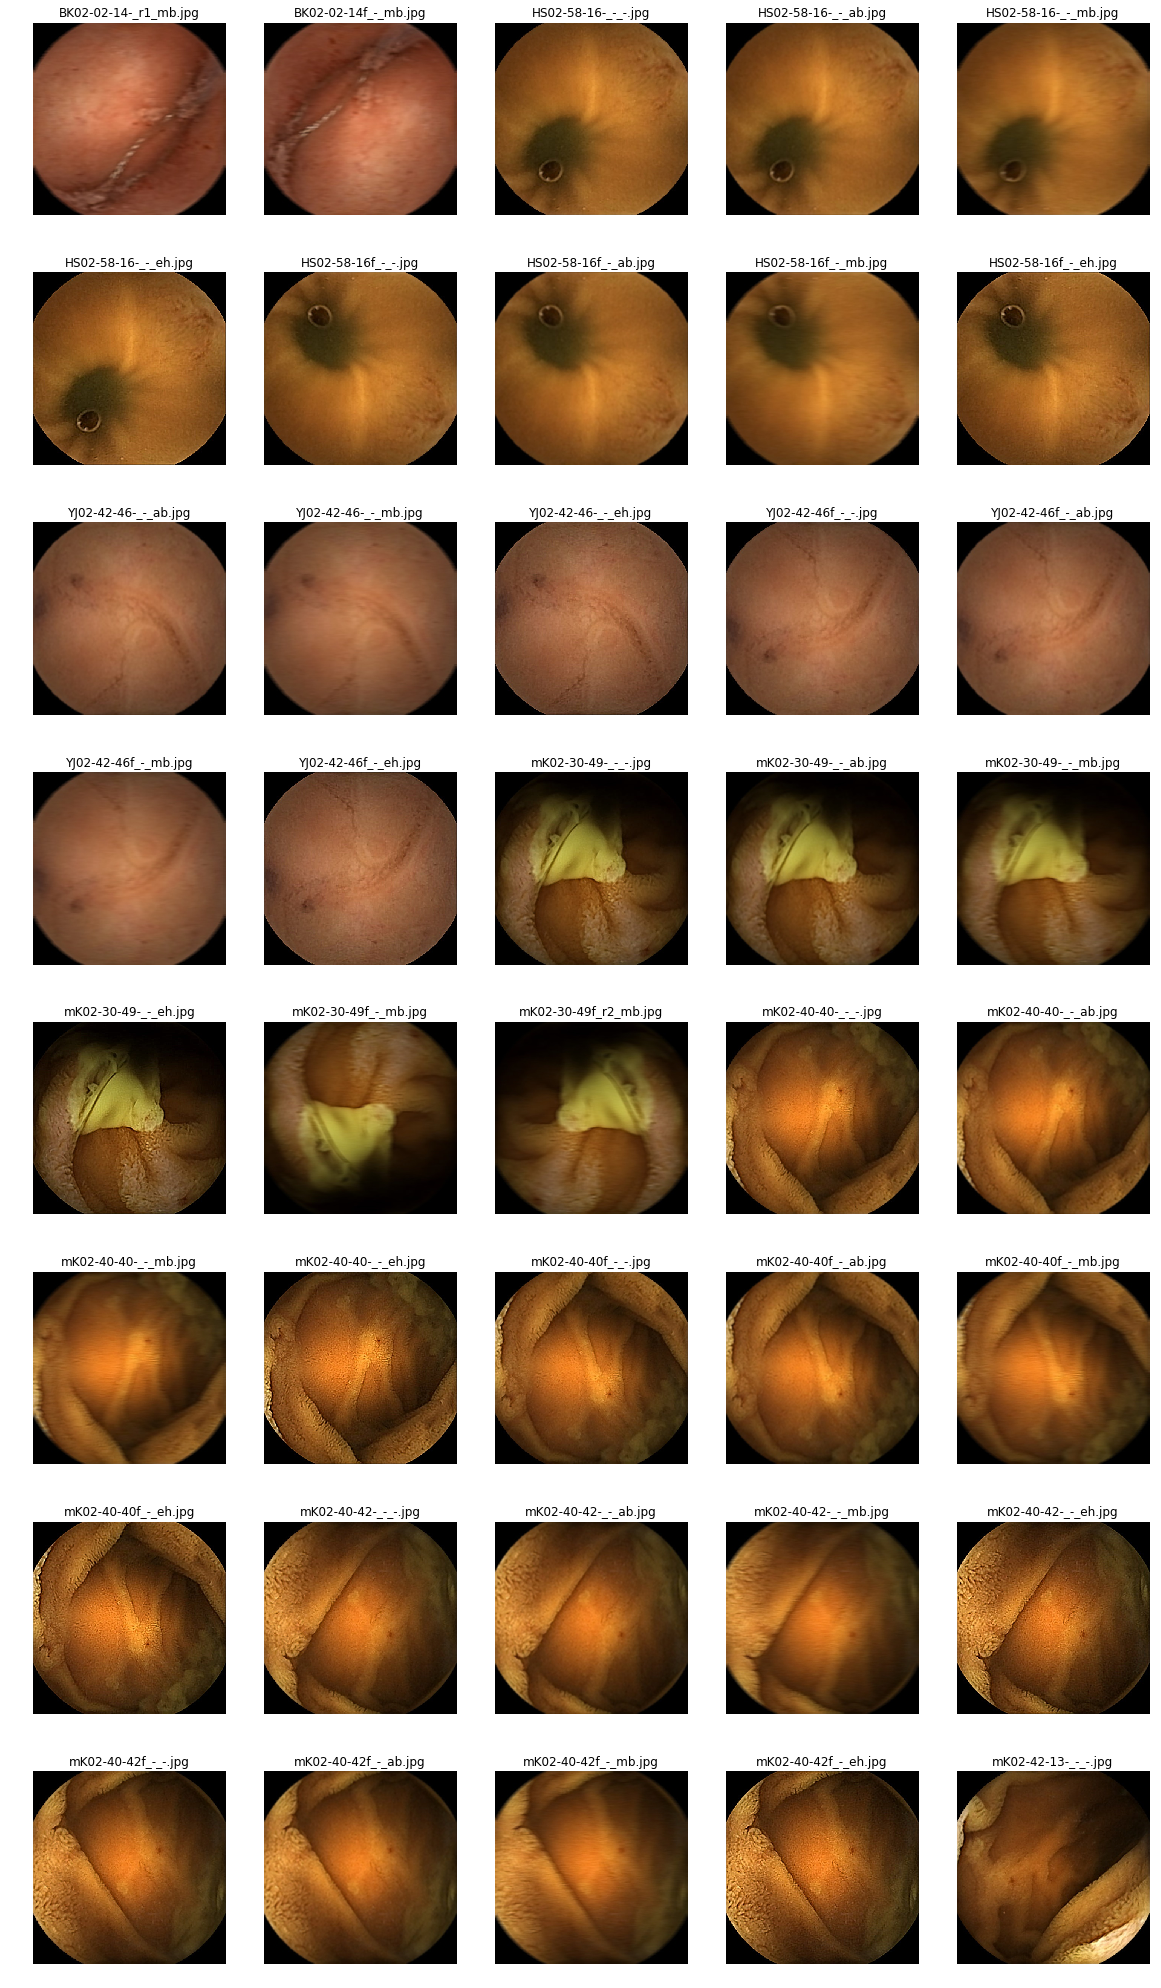

In [27]:
plt.figure(figsize = (20, 36))
for i, name, img in zip(range(len(b_fn_testset)), b_fn_list, b_fn_testset):
    if i+1 > 40:
        break
    plt.subplot(8, 5, i+1)
    plt.title(name.split('___')[0] + name.split('___')[1] + name.split('c_')[-1])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

## ROC curve

In [28]:
from scipy.stats import sem, t
from scipy import mean
from sklearn.model_selection import KFold

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [29]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, h_idxs = k_fold_idx(n_fold = n_g, dataset = h_label)
_, d_idxs = k_fold_idx(n_fold = n_g, dataset = d_label)

In [30]:
def tri_shuffle(x, y, z):
    rand_idx = np.random.choice(len(x), len(x), replace = False)
    return x[rand_idx], y[rand_idx], z[rand_idx]

In [31]:
h_label, h_b_output, h_e_output = tri_shuffle(h_label, h_b_output, h_e_output)
d_label, d_b_output, d_e_output = tri_shuffle(d_label, d_b_output, d_e_output)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


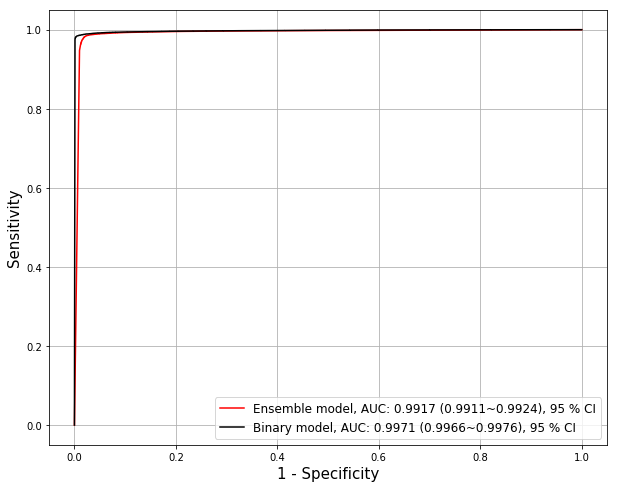

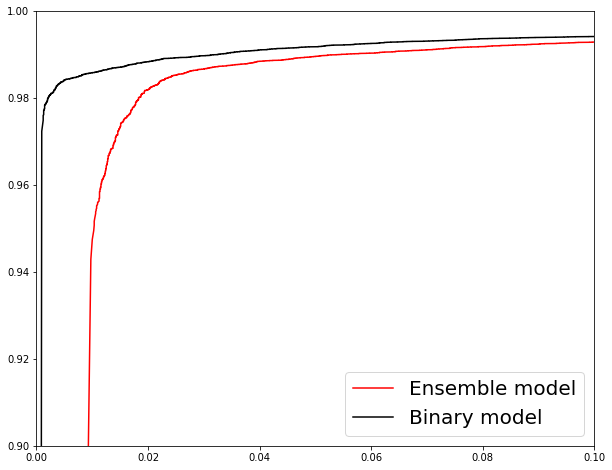

In [32]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):

    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

labels = np.vstack([neg_label, h_label, d_label])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

labels, b_outputs, e_outputs = tri_shuffle(labels, b_outputs, e_outputs)

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [33]:
e_CM, b_CM = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):
    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

In [34]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [35]:
b_metrices

array([[0.98862696, 0.98966165, 0.98103448, 0.92822186, 0.99739522],
       [0.98717949, 0.98930921, 0.97155172, 0.92528736, 0.99609652],
       [0.98800538, 0.9900141 , 0.9732528 , 0.9299258 , 0.99633483],
       [0.98676455, 0.98848684, 0.97411562, 0.9201304 , 0.99644718],
       [0.98779857, 0.98895677, 0.97929249, 0.92351505, 0.99715707],
       [0.98831558, 0.98966165, 0.97842968, 0.92798691, 0.99704107],
       [0.98614414, 0.98789944, 0.9732528 , 0.91632819, 0.99632701],
       [0.98810878, 0.98977914, 0.97584124, 0.92857143, 0.99668757],
       [0.98728156, 0.98966165, 0.96980155, 0.92739274, 0.9958624 ],
       [0.98707476, 0.98883929, 0.97411562, 0.92238562, 0.99644844]])

In [36]:
e_metrices

array([[0.98542184, 0.99024906, 0.95      , 0.92995781, 0.99316602],
       [0.98242349, 0.98789944, 0.94224138, 0.9138796 , 0.99209533],
       [0.98521352, 0.98942669, 0.95427092, 0.92474916, 0.99374631],
       [0.98552373, 0.9887218 , 0.96203624, 0.92072667, 0.99479905],
       [0.98624754, 0.9906015 , 0.95427092, 0.93254637, 0.99375368],
       [0.98511012, 0.98883929, 0.95772217, 0.92116183, 0.99421214],
       [0.98531693, 0.98825188, 0.96376186, 0.91783073, 0.99503194],
       [0.98293868, 0.9881344 , 0.94477998, 0.91555184, 0.99244838],
       [0.98531693, 0.98966165, 0.95340811, 0.92623638, 0.99363057],
       [0.98500672, 0.98883929, 0.95685936, 0.92109635, 0.99409472]])

In [37]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 98.75 (98.70 ~ 98.81)
Sen --- 98.92 (98.87 ~ 98.97)
Spec --- 97.51 (97.25 ~ 97.76)
NPV --- 92.50 (92.19 ~ 92.81)
PPV --- 99.66 (99.62 ~ 99.69)

Ensemble model
Accr --- 98.49 (98.40 ~ 98.57)
Sen --- 98.91 (98.84 ~ 98.97)
Spec --- 95.39 (94.90 ~ 95.88)
NPV --- 92.24 (91.81 ~ 92.67)
PPV --- 99.37 (99.30 ~ 99.44)


### Equal-Variance Test

In [38]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 1.609, pvalue=0.204640843358
bartlett test for sensitivity: 0.759, pvalue=0.383577828019
bartlett test for specificity: 3.419, pvalue=0.064434416486
bartlett test for negative predictive values: 0.893, pvalue=0.344741389058
bartlett test for positive predictive values: 3.388, pvalue=0.065663491526


In [39]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.044, pvalue=0.836846277610
levene test for sensitivity: 0.492, pvalue=0.492222809736
levene test for specificity: 2.158, pvalue=0.159094960662
levene test for negative predictive values: 0.543, pvalue=0.470530059419
levene test for positive predictive values: 2.120, pvalue=0.162653997824


### Normality Test

In [40]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for sensitivity: 0.300, pvalue=0.786929788478
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 0.400, pvalue=0.417523652818
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [41]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 14.500, pvalue=0.623638826128
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for negative predictive values: 18.000, pvalue=0.332879754568
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Paired two-sample t-Test (normal and paired group)

In [42]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 5.869, pvalue=0.000238089594
t-statistics for sensitivity: 0.530, pvalue=0.609054173534
t-statistics for specificity: 8.641, pvalue=0.000011901876
t-statistics for negative predictive values: 1.241, pvalue=0.246125030960
t-statistics for positive predictive values: 8.640, pvalue=0.000011906017


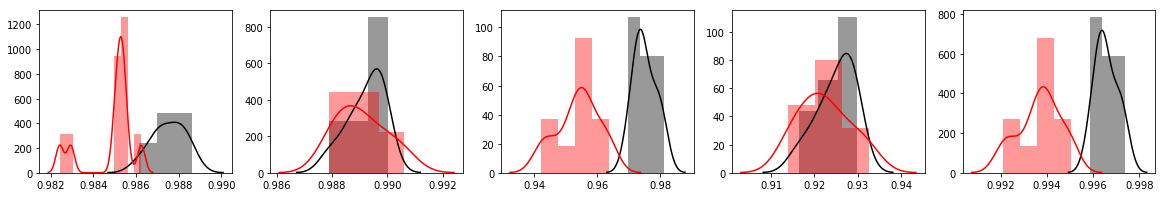

In [43]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()